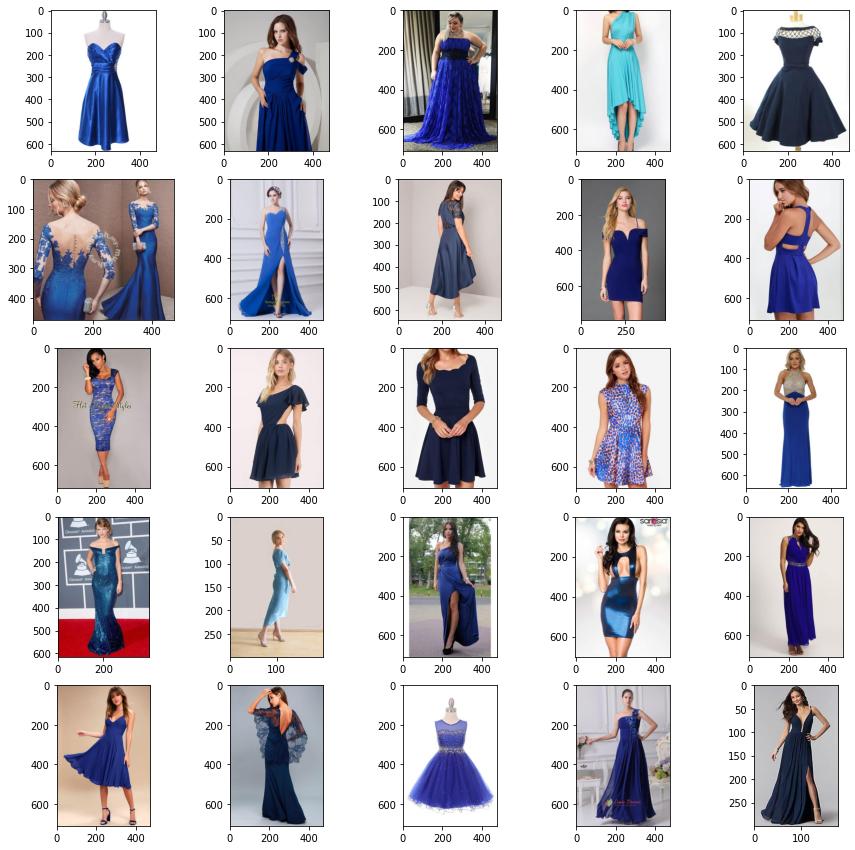

In [5]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = 'dataset/blue_dress'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

Found 3360 images belonging to 21 classes.
Found 840 images belonging to 21 classes.


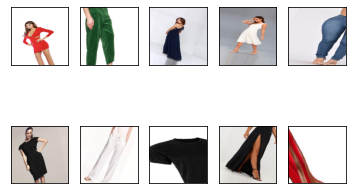

In [6]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [18]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [19]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [24]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(21, activation='softmax')
])

In [25]:
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 21)                26901     
                                                                 
Total params: 2,284,885
Trainable params: 26,901
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=[32],
    validation_data=data_gen_pruebas
)

Epoch 1/50
105/105 [==============================] - 130s 1s/step - loss: 1.7030 - accuracy: 0.4905 - val_loss: 1.0072 - val_accuracy: 0.7179
Epoch 2/50
105/105 [==============================] - 128s 1s/step - loss: 0.8565 - accuracy: 0.7473 - val_loss: 0.7153 - val_accuracy: 0.7976
Epoch 3/50
105/105 [==============================] - 129s 1s/step - loss: 0.6824 - accuracy: 0.7982 - val_loss: 0.6505 - val_accuracy: 0.7976
Epoch 4/50
105/105 [==============================] - 124s 1s/step - loss: 0.5883 - accuracy: 0.8238 - val_loss: 0.6558 - val_accuracy: 0.7857
Epoch 5/50
105/105 [==============================] - 134s 1s/step - loss: 0.5370 - accuracy: 0.8321 - val_loss: 0.5707 - val_accuracy: 0.8310
Epoch 6/50
105/105 [==============================] - 124s 1s/step - loss: 0.4992 - accuracy: 0.8414 - val_loss: 0.5331 - val_accuracy: 0.8333
Epoch 7/50
105/105 [==============================] - 125s 1s/step - loss: 0.4759 - accuracy: 0.8470 - val_loss: 0.5315 - val_accuracy: 0.8417

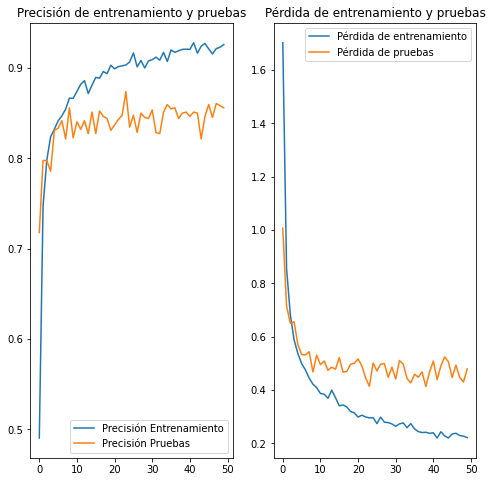

In [28]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [29]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)


In [31]:
#0 = black dress, 1 = black pants, 2 = black shirt, 3 = black shoes, 4 = black shorts, 5 = blue dress, 6 = blue pants, 7 = blue shirt, 8 = blue shoes
#, 9 = blue shorts, 10 = brown pants, 11 = brown shoes, 12 = green pants, 13 = green shirt, 14= green shoes, 15 = red dress, 16 = red pants, 
# 17 = red shoes, 18 = white dress, 19 = white pants, 20 = whrite shoes

from IPython import display
url = 'https://dsnegsjxz63ti.cloudfront.net/images/pg/g_325ff628c38f54a.jpg' 
try:
    prediccion = categorizar (url)
    print(f"Esta prenda se encuentra en la clase {classes[prediccion]} ") 
except:
    print("no lo pudo relacionar o hay varias prendas en la imagen")

display.Image("https://dsnegsjxz63ti.cloudfront.net/images/pg/g_325ff628c38f54a.jpg", width=225)

1/1 [==============================] - 0s 46ms/step
19
